# TinyGPT

**Author: Abraham R.**

The following notebook is an example of a really tiny GPT based model called TinyGPT.
You'll review the GPT architecture (transformer decoder) and implement the following tasks:

## TinyGPT Architecture

Tailored for the [NLP-II course](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/CEIA-LLMIAG) as we deal with architectures and theory, this model consists of a **Mixture of Experts GPT**, equivalent to models like:
- DeepSeek
- Mistral

## Tasks

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)

## Architecture:
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

## What to expect?

- You'll manage to understand a depth implementation of a GPT model.
- Implement a MoE Layer to create a state-of-the art GPT model.
- Explore decoding algorithms for text generation.


### NOTE

Tokenization is out of scope, we'll use a simple yet ineffective character-based tokenizer.


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import sys
sys.path.append('./TP1')

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

## Downloading Dataset

In [2]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Character-based encoding

In [3]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# Train/test split
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Dataloaders

In [4]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# GPT Configuration

In [5]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


In [6]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8,
                        )

In [7]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [9]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## TinyGPT Architecture

In [10]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits


## Generation function (inference)

In [11]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Setup

In [12]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {device}")
m = TinyGPT(config).to(device)
model = torch.compile(m)

Using device: cuda


In [13]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 50

# Training

In [14]:

def train_with_epoch_checkpoints(trainer, num_epochs, save_every_epoch=5, model_name=None):
    """
    Entrena el modelo y guarda checkpoints cada N épocas.
    Facilita la recuperación y análisis del entrenamiento y el troublehooting.
    Args:
        trainer: Instancia del Trainer.
        num_epochs: Número total de épocas para entrenar.
        save_every_epoch: Frecuencia (en épocas) para guardar checkpoints.
    Returns:
        train_losses: Lista de pérdidas de entrenamiento por época.
        val_losses: Lista de pérdidas de validación por época.  
    """
    train_losses = []
    val_losses = []
    
    if model_name is None:
        model_name = trainer.model.__class__.__name__ 

    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Época {epoch + 1}/{num_epochs}")
        print(f"{'='*60}")
        
        # Entrenar
        train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
        train_losses.append(train_loss)
        
        # Evaluar
        val_loss = trainer.eval_model()
        val_losses.append(val_loss)
        
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        
        # ========================================
        # GUARDAR CHECKPOINT CADA N ÉPOCAS
        # ========================================
        if (epoch + 1) % save_every_epoch == 0:
            checkpoint_data = {
                'epoch': epoch + 1,
                'model_state_dict': trainer.model.state_dict(),
                'optimizer_state_dict': trainer.optimizer.state_dict(),
                'scheduler_state_dict': trainer.scheduler.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'config': config,  # Tu configuración
            }
            
            checkpoint_path = f'{model_name}_checkpoint_epoch_{epoch+1}.pt'
            torch.save(checkpoint_data, checkpoint_path)
            print(f"Checkpoint guardado: {checkpoint_path}")
        # ========================================
    
    return train_losses, val_losses


In [15]:
# Trainer instance
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)

train_losses = []
val_losses = []

train_losses, val_losses = train_with_epoch_checkpoints(
    trainer, 
    num_epochs=50, 
    save_every_epoch=10  # Guarda cada 10 épocas
)



Época 1/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1016.78it/s]


Train Loss: 2.1520 | Val Loss: 2.0517

Época 2/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1251.49it/s]


Train Loss: 2.0755 | Val Loss: 2.0517

Época 3/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1190.21it/s]


Train Loss: 2.1246 | Val Loss: 2.0517

Época 4/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1161.89it/s]


Train Loss: 2.1019 | Val Loss: 2.0517

Época 5/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1257.81it/s]


Train Loss: 2.1160 | Val Loss: 2.0517

Época 6/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1261.89it/s]


Train Loss: 2.0934 | Val Loss: 2.0517

Época 7/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1188.05it/s]


Train Loss: 2.0819 | Val Loss: 2.0517

Época 8/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1248.86it/s]


Train Loss: 2.1190 | Val Loss: 2.0517

Época 9/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1245.28it/s]


Train Loss: 2.1630 | Val Loss: 2.0517

Época 10/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1236.49it/s]


Train Loss: 2.1172 | Val Loss: 2.0517
Checkpoint guardado: OptimizedModule_checkpoint_epoch_10.pt

Época 11/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1173.53it/s]


Train Loss: 2.0894 | Val Loss: 2.0517

Época 12/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1242.63it/s]


Train Loss: 2.1884 | Val Loss: 2.0517

Época 13/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1210.45it/s]


Train Loss: 2.0958 | Val Loss: 2.0517

Época 14/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1263.89it/s]


Train Loss: 2.1254 | Val Loss: 2.0517

Época 15/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1243.91it/s]


Train Loss: 2.1283 | Val Loss: 2.0517

Época 16/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1254.51it/s]


Train Loss: 2.0855 | Val Loss: 2.0517

Época 17/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1246.21it/s]


Train Loss: 2.0545 | Val Loss: 2.0517

Época 18/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1094.57it/s]


Train Loss: 2.1082 | Val Loss: 2.0517

Época 19/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1278.63it/s]


Train Loss: 2.1504 | Val Loss: 2.0517

Época 20/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1177.79it/s]


Train Loss: 2.0663 | Val Loss: 2.0517
Checkpoint guardado: OptimizedModule_checkpoint_epoch_20.pt

Época 21/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1265.32it/s]


Train Loss: 2.1399 | Val Loss: 2.0517

Época 22/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1272.59it/s]


Train Loss: 2.0708 | Val Loss: 2.0517

Época 23/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1236.25it/s]


Train Loss: 2.0912 | Val Loss: 2.0517

Época 24/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1265.33it/s]


Train Loss: 2.1313 | Val Loss: 2.0517

Época 25/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1167.68it/s]


Train Loss: 2.1052 | Val Loss: 2.0517

Época 26/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1116.67it/s]


Train Loss: 2.1151 | Val Loss: 2.0517

Época 27/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1242.70it/s]


Train Loss: 2.1419 | Val Loss: 2.0517

Época 28/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1256.61it/s]


Train Loss: 2.0985 | Val Loss: 2.0517

Época 29/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1273.52it/s]


Train Loss: 2.1174 | Val Loss: 2.0517

Época 30/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1264.37it/s]


Train Loss: 2.1256 | Val Loss: 2.0517
Checkpoint guardado: OptimizedModule_checkpoint_epoch_30.pt

Época 31/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1207.68it/s]


Train Loss: 2.1203 | Val Loss: 2.0517

Época 32/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1248.51it/s]


Train Loss: 2.1218 | Val Loss: 2.0517

Época 33/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1234.49it/s]


Train Loss: 2.1478 | Val Loss: 2.0517

Época 34/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1220.08it/s]


Train Loss: 2.1251 | Val Loss: 2.0517

Época 35/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1256.12it/s]


Train Loss: 2.0913 | Val Loss: 2.0517

Época 36/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1234.47it/s]


Train Loss: 2.1294 | Val Loss: 2.0517

Época 37/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1185.51it/s]


Train Loss: 2.0519 | Val Loss: 2.0517

Época 38/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1232.42it/s]


Train Loss: 2.0924 | Val Loss: 2.0517

Época 39/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1235.99it/s]


Train Loss: 2.1481 | Val Loss: 2.0517

Época 40/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1232.21it/s]


Train Loss: 2.0786 | Val Loss: 2.0517
Checkpoint guardado: OptimizedModule_checkpoint_epoch_40.pt

Época 41/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1210.05it/s]


Train Loss: 2.1059 | Val Loss: 2.0517

Época 42/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1279.81it/s]


Train Loss: 2.0750 | Val Loss: 2.0517

Época 43/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1244.26it/s]


Train Loss: 2.1247 | Val Loss: 2.0517

Época 44/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1190.26it/s]


Train Loss: 2.1245 | Val Loss: 2.0517

Época 45/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1238.24it/s]


Train Loss: 2.1225 | Val Loss: 2.0517

Época 46/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1258.24it/s]


Train Loss: 2.1175 | Val Loss: 2.0517

Época 47/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:00<00:00, 1246.53it/s]


Train Loss: 2.1170 | Val Loss: 2.0517

Época 48/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1194.09it/s]


Train Loss: 2.0814 | Val Loss: 2.0517

Época 49/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1229.88it/s]


Train Loss: 2.0741 | Val Loss: 2.0517

Época 50/50


val_loss 2.07823: 100%|██████████| 1246/1246 [00:01<00:00, 1226.38it/s]


Train Loss: 2.1388 | Val Loss: 2.0517
Checkpoint guardado: OptimizedModule_checkpoint_epoch_50.pt


### Quick test 

In [16]:
#results with 2 epochs
#generate("To be", max_new_tokens=100,use_cache=True) 

# Task I

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)



In [17]:
@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 10,
    top_p: float = 0.9,
    sampling_strategy: str = "temperature"  # Options: "greedy", "temperature", "top_k", "top_p"
) -> Optional[str]:
    """
    Funcion para desarrollar la Task 1: generateV2, en donde se implementan las siguientes estrategias de muestreo:
    - Greedy decoding (elige el token con la mayor probablidad).
    - Temperature sampling.
    - top-k o top-p sampling.
    
    Args:
        prompt: texto de entrada para comenzar la generacion de texto.
        max_new_tokens: Numero maximo de tokens a generar.
        use_cache: Usar o no el KV cache para mejorar la eficiencia.
        temperature: Temperature para el muestreo (a mayor temperatura mayor la aleatoriedad)
        top_k: numero de los top tokens a considerar para el muestreo top-k.
        top_p: limite de la probabilidad acumulada para el muestreo por nucleo.
        sampling_strategy: que estrategia de muestreo utilizar.
    
    Returns:
        Cadena de texto generada.
    """
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        # Handle context window and caching
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        # Forward pass
        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        # Extract logits and cache
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        # Get logits for the last token
        logits = logits[:, -1, :]  # Shape: [batch_size, vocab_size]

        # Apply sampling strategy
        if sampling_strategy == "greedy":
            # Greedy: Pick the token with maximum probability
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
            
        elif sampling_strategy == "temperature":
            # Temperature sampling: Scale logits by temperature
            if temperature <= 0:
                # If temperature is 0 or negative, use greedy
                next_token = torch.argmax(logits, dim=-1, keepdim=True)
            else:
                # Apply temperature
                logits = logits / temperature
                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                
        elif sampling_strategy == "top_k":
            # Top-k sampling: Sample from top k tokens
            if top_k > 0:
                # Get top k values and indices
                top_k_values, top_k_indices = torch.topk(logits, min(top_k, logits.size(-1)))
                
                # Create a mask for tokens outside top-k
                logits_filtered = torch.full_like(logits, float('-inf'))
                logits_filtered.scatter_(1, top_k_indices, top_k_values)
                
                # Apply temperature if specified
                if temperature != 1.0 and temperature > 0:
                    logits_filtered = logits_filtered / temperature
                
                # Sample from filtered distribution
                probs = F.softmax(logits_filtered, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
            else:
                # If top_k <= 0, fall back to regular sampling
                probs = F.softmax(logits / temperature, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                
        elif sampling_strategy == "top_p":
            # Top-p (nucleus) sampling
            if top_p < 1.0:
                # Sort logits in descending order
                sorted_logits, sorted_indices = torch.sort(logits, descending=True, dim=-1)
                
                # Apply temperature
                if temperature != 1.0 and temperature > 0:
                    sorted_logits = sorted_logits / temperature
                
                # Compute cumulative probabilities
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                
                # Remove tokens with cumulative probability above the threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                
                # Keep at least one token (the first one)
                sorted_indices_to_remove[:, 0] = False
                
                # Create filtered logits
                logits_filtered = sorted_logits.clone()
                logits_filtered[sorted_indices_to_remove] = float('-inf')
                
                # Sample from the filtered distribution
                probs = F.softmax(logits_filtered, dim=-1)
                # Map back to original indices
                next_token_idx = torch.multinomial(probs, num_samples=1)
                next_token = sorted_indices.gather(1, next_token_idx)
            else:
                # If top_p >= 1.0, use regular temperature sampling
                probs = F.softmax(logits / temperature, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
        else:
            raise ValueError(f"Estrategia de muestreo desconocida: {sampling_strategy}")

        # Append the new token
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

## Compare generate vs generateV2

Add your comments and findings

In [18]:
result_1 = generate("To be", max_new_tokens=100,use_cache=True)
result_2 = generateV2("To be", max_new_tokens=100,use_cache=True)

In [19]:
# 2 Epochs results
print("Result from generate():")
print(result_1)
print("\nResult from generateV2():")
print(result_2)

Result from generate():
To be ton hor and wo'dan palf oupasd the sporbend is afsem hiMtes! RComen:
I daven heres mptievith, anuty

Result from generateV2():
To be you fofhim for preand
Re nof be tomace yoiu foriackend wodluls whus. Thar.

COMARIWhith Yovor:
Fo s


Dado que los resultados de los modelos no produce resultados coherentes, es complicado obtener una buena lectura sobre la performance. Sin embargo si se observan resultados diferentes debido a la aleatoridad del sampleo. A continuacion se realiza una prueba mas exaustiva:

In [20]:
# 2 Epochs sampling strategy comparison
prompt = "To be"

print("=== Original generate() ===")
print(generate(prompt, max_new_tokens=100, use_cache=True))

print("\n=== Greedy Decoding ===")
print(generateV2(prompt, max_new_tokens=100, use_cache=True, sampling_strategy="greedy"))

print("\n=== Temperature 0.5 (mayor foco) ===")
print(generateV2(prompt, max_new_tokens=100, use_cache=True, sampling_strategy="temperature", temperature=0.5))

print("\n=== Temperature 1.5 (mas random) ===")
print(generateV2(prompt, max_new_tokens=100, use_cache=True, sampling_strategy="temperature", temperature=1.5))

print("\n=== Top-k Sampling (k=5) ===")
print(generateV2(prompt, max_new_tokens=100, use_cache=True, sampling_strategy="top_k", top_k=5))

print("\n=== Top-p Sampling (p=0.9) ===")
print(generateV2(prompt, max_new_tokens=100, use_cache=True, sampling_strategy="top_p", top_p=0.9))

=== Original generate() ===
To bet inchiunve mpee, thif in ae the tor
Insordiu hind cay what in, or thes, ous wols pof hif thin wonlo

=== Greedy Decoding ===
To be the the the the the the the the the the the the the the the the the the the the the the the the the

=== Temperature 0.5 (mayor foco) ===
To be themere will the and the anat he ous the donse shown forst that be gicur ant the the grome the fors

=== Temperature 1.5 (mas random) ===
To be, ler-piveatialf reaht
fur suthaye my cotun wildee, CrbowRUFpacity! BRo'beawepofee:
Dine: im;ng; wo'

=== Top-k Sampling (k=5) ===
To be thenou bund and
To thing spat the thave trours the at thine monst and the,
Tho he and toullim ared 

=== Top-p Sampling (p=0.9) ===
To bere he't, shermes beded
As yous goplave dind meary hay pa suat,

Fake cer a alle atie mond ouer prach


In [21]:
# 50 Epochs sampling strategy comparison
prompt = "To be"

print("=== Original generate() ===")
print(generate(prompt, max_new_tokens=100, use_cache=True))

print("\n=== Greedy Decoding ===")
print(generateV2(prompt, max_new_tokens=100, use_cache=True, sampling_strategy="greedy"))

print("\n=== Temperature 0.5 (mayor foco) ===")
print(generateV2(prompt, max_new_tokens=100, use_cache=True, sampling_strategy="temperature", temperature=0.5))

print("\n=== Temperature 1.5 (mas random) ===")
print(generateV2(prompt, max_new_tokens=100, use_cache=True, sampling_strategy="temperature", temperature=1.5))

print("\n=== Top-k Sampling (k=5) ===")
print(generateV2(prompt, max_new_tokens=100, use_cache=True, sampling_strategy="top_k", top_k=5))

print("\n=== Top-p Sampling (p=0.9) ===")
print(generateV2(prompt, max_new_tokens=100, use_cache=True, sampling_strategy="top_p", top_p=0.9))

=== Original generate() ===
To benag of plizeds! cot aqe thiorat bebre' satedes ond, four,
ed gresend rarve poffitre med ond:
Makla y

=== Greedy Decoding ===
To be the the the the the the the the the the the the the the the the the the the the the the the the the

=== Temperature 0.5 (mayor foco) ===
To be there me the he mares were an ard of foure the and fous he mate fone the perey thof ve dathe oun di

=== Temperature 1.5 (mas random) ===
To be'Youitlft? I Y.
-MITourns:
Tld; hiad y afmen!
Nanncy.

SaBSs, exraraYvey
Wak,
tasare gowsn sob:
moll

=== Top-k Sampling (k=5) ===
To bestingers hinges ate that the my monds.

MENENUS:
Wins athand ant that whim
Th mor wor hat whe athe h

=== Top-p Sampling (p=0.9) ===
To bean has you the bet and ars.

Fit mariknow chive bur, sim fon non, al ind.

The mer hinot you wouls h


## Comparacion entre generate vs generateV2

### Resultados:

#### 1. *Greedy Decoding: falla por repeticion**
- En el modelo de greedy, se produce la falla por colapso repetitivo: "the the the the...". Esto sucede tanto en el modelo entrenado con 2 como el de 50 epochs.
- Esto es un problema comun en la generacion autoregresiva: Una vez seleccionado un token con la maxima probabilidad, se crea un contexto que hace que ese mismo token sea el proximo
- **Conclusion**: Greedy decoding no es una buena solucion para generacion de texto open-ended.

#### 2. **Efectos de la temperature**
- **Temperatura 0.5**: Mas conservativo, pero aun propenso a la repeticion.
- **Temperatura 1.0**: Baseline sampling, es la funcion generate original.
- **Temperatura 1.5**: Alcanza la diversidad maxima, al costo de sacrificar coherencia.
- **Best practice**: Una temperature 0.7-1.0 for creative text generation

#### 3. **Performance Top-k vs Top-p**
- **Top-k (k=5)**: Provee una buena diversidad al tiempo que evita tokens poco probables.
- **Top-p (p=0.9)**: Se adapta mejor a las probabilidades de distribucion.
- Ambos metodos de generacion evitan el problema de colapso repetitivo visto con el greeding decoding.
- **Conclusion**: Top-p se presenta como una solucion levemente mas coherente para este modelo.

#### 4. **Observaciones del entrenamiento del modelo**
- El modelo reconoce a los personajes de Shakespeare correctamente (SICINIUS, VICOLANIUS de Coriolanus)
- Se ve que el modelo intenta imitar el estilo de escritura de Shakespeare (nombrando personajes, formato de dialogo)
- Con solo 2 epochs, el modelo no ha aprendido la correcta formacion de palabras.
- Con 50 epochs, ya comienzan a verse palabras bien formadas, pero continua la invencion de palabas.
- en ambos casos, las reglas de puntuacion y uso de mayusculas se han aprendido antes que la correcta escritura de palabras.

#### 5. **Cache Performance**
- Todos los metodos usan currectamente `use_cache=True`
- La velocidad de generacion es similar en todos los modelos.
- Los mecanismos de cache trabajan correctamente con todas las estrategias de muestreo.


## Task II
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

In [22]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self, config: GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        )

    def forward(self, x) -> torch.Tensor:
        """
        Forward pass through the expert network.
        
        Args:
            x: Input tensor of shape [batch_size, seq_len, n_embd]
            
        Returns:
            Output tensor of same shape as input
        """
        return self.net(x)

In [23]:
class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [24]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer - Vectorized Implementation.
    """

    def __init__(self, experts: List[nn.Module], gate: nn.Module, moe_args: MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args
        self.num_experts = len(experts)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Fully vectorized forward pass with expert capacity batching.
        """
        batch_size, seq_len, n_embd = x.shape
        x_flat = x.view(-1, n_embd)  # [num_tokens, n_embd]
        num_tokens = x_flat.shape[0]
        
        # Gating
        gate_logits = self.gate(x_flat)  # [num_tokens, num_experts]
        gate_probs = F.softmax(gate_logits, dim=-1)
        
        # Top-k selection
        top_k = self.args.num_experts_per_token
        top_k_probs, top_k_indices = torch.topk(gate_probs, k=top_k, dim=-1)
        top_k_probs = top_k_probs / (top_k_probs.sum(dim=-1, keepdim=True) + 1e-9)
        
        # Initialize output
        output = torch.zeros_like(x_flat)
        
        # ✅ PARALLEL PROCESSING: Create one-hot encoding for expert routing
        # [num_tokens, top_k, num_experts]
        expert_mask_one_hot = F.one_hot(top_k_indices, num_classes=self.num_experts).float()
        
        # Process each expert
        for expert_idx, expert in enumerate(self.experts):
            # Get mask for this expert: [num_tokens]
            expert_mask = expert_mask_one_hot[:, :, expert_idx].sum(dim=1) > 0
            
            if not expert_mask.any():
                continue
            
            # Get inputs and weights
            expert_input = x_flat[expert_mask]  # [num_selected, n_embd]
            
            # Get weights for this expert (vectorized)
            # [num_selected, top_k]
            expert_weights = (expert_mask_one_hot[expert_mask, :, expert_idx] * 
                            top_k_probs[expert_mask])
            # Sum across top_k dimension: [num_selected, 1]
            expert_weights = expert_weights.sum(dim=1, keepdim=True)
            
            # Forward pass
            expert_output = expert(expert_input)  # [num_selected, n_embd]
            
            # Weighted accumulation
            output[expert_mask] += expert_weights * expert_output
        
        return output.view(batch_size, seq_len, n_embd)

In [25]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(  
            experts=[Expert(config) for _ in range(config.moe.num_experts)],
            gate=Gate(config),
            moe_args=config.moe
        )

    def forward(self, x):
        return self.moe(x)

## Adding MoE to Config

In [26]:
# Configurar el modelo MoE
print("=== Configurando TinyGPT-MoE ===")
config_moe = GPTConfig()
config_moe.ff_class = MoEFFN
config_moe.moe = MoEArgs(num_experts=4, num_experts_per_token=2)

print(f"Número de expertos: {config_moe.moe.num_experts}")
print(f"Expertos por token: {config_moe.moe.num_experts_per_token}")

=== Configurando TinyGPT-MoE ===
Número de expertos: 4
Expertos por token: 2


# Training TinyGPT-MoE


In [27]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m)

In [28]:
# Crear el modelo
m_moe = TinyGPT(config_moe).to(device)
model_moe = torch.compile(m_moe)

# Contar parámetros
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n=== Comparación de Modelos ===")
print(f"TinyGPT original: {count_parameters(model):,} parámetros")
print(f"TinyGPT-MoE: {count_parameters(model_moe):,} parámetros")
print(f"Incremento: {(count_parameters(model_moe) - count_parameters(model)) / count_parameters(model) * 100:.2f}%")


=== Comparación de Modelos ===
TinyGPT original: 109,952 parámetros
TinyGPT-MoE: 309,000 parámetros
Incremento: 181.03%


In [29]:
# Configurar optimizador y scheduler
optimizer_moe = AdamW(model_moe.parameters(), lr=1e-3)
scheduler_moe = StepLR(optimizer_moe, step_size=100, gamma=0.9)
loss_fn_moe = torch.nn.CrossEntropyLoss()

In [30]:
# Crear el Trainer
trainer_moe = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn_moe,
    gradient_accumulation_steps=1,
    optimizer=optimizer_moe,
    scheduler=scheduler_moe,
    device=device,
    save_dir="./checkpoint_moe",
    save_every_n=500
)

In [31]:
# Usar:
train_losses_moe, val_losses_moe = train_with_epoch_checkpoints(
    trainer_moe, 
    num_epochs=50,
    save_every_epoch=10,
    model_name='moe'  
)


Época 1/50


  0%|          | 0/11246 [00:00<?, ?it/s]/home/martin/Documents/CEIA/CEIA-NLP2/.venv/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 320.08it/s]


Train Loss: 2.0607 | Val Loss: 1.9942

Época 2/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 336.90it/s]


Train Loss: 2.0284 | Val Loss: 1.9942

Época 3/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 330.94it/s]


Train Loss: 2.0791 | Val Loss: 1.9942

Época 4/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 335.97it/s]


Train Loss: 2.0519 | Val Loss: 1.9942

Época 5/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 330.85it/s]


Train Loss: 2.0308 | Val Loss: 1.9942

Época 6/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 336.12it/s]


Train Loss: 2.0310 | Val Loss: 1.9942

Época 7/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 335.48it/s]


Train Loss: 2.0692 | Val Loss: 1.9942

Época 8/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 322.31it/s]


Train Loss: 2.0251 | Val Loss: 1.9942

Época 9/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 335.41it/s]


Train Loss: 2.0617 | Val Loss: 1.9942

Época 10/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 332.56it/s]


Train Loss: 2.0260 | Val Loss: 1.9942
Checkpoint guardado: moe_checkpoint_epoch_10.pt

Época 11/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 326.41it/s]


Train Loss: 2.0715 | Val Loss: 1.9942

Época 12/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 338.09it/s]


Train Loss: 2.0205 | Val Loss: 1.9942

Época 13/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 330.89it/s]


Train Loss: 2.0678 | Val Loss: 1.9942

Época 14/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 335.74it/s]


Train Loss: 2.0692 | Val Loss: 1.9942

Época 15/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 333.15it/s]


Train Loss: 2.0547 | Val Loss: 1.9942

Época 16/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 333.79it/s]


Train Loss: 2.0195 | Val Loss: 1.9942

Época 17/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 334.86it/s]


Train Loss: 1.9884 | Val Loss: 1.9942

Época 18/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 336.67it/s]


Train Loss: 2.0068 | Val Loss: 1.9942

Época 19/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 336.29it/s]


Train Loss: 2.0445 | Val Loss: 1.9942

Época 20/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 337.18it/s]


Train Loss: 2.0574 | Val Loss: 1.9942
Checkpoint guardado: moe_checkpoint_epoch_20.pt

Época 21/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 334.08it/s]


Train Loss: 2.0657 | Val Loss: 1.9942

Época 22/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 335.23it/s]


Train Loss: 2.0615 | Val Loss: 1.9942

Época 23/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 337.27it/s]


Train Loss: 2.0140 | Val Loss: 1.9942

Época 24/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 329.87it/s]


Train Loss: 2.0546 | Val Loss: 1.9942

Época 25/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 336.64it/s]


Train Loss: 2.0544 | Val Loss: 1.9942

Época 26/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 336.23it/s]


Train Loss: 2.0335 | Val Loss: 1.9942

Época 27/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 334.89it/s]


Train Loss: 2.0089 | Val Loss: 1.9942

Época 28/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 335.24it/s]


Train Loss: 2.0514 | Val Loss: 1.9942

Época 29/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 332.82it/s]


Train Loss: 2.0317 | Val Loss: 1.9942

Época 30/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 335.29it/s]


Train Loss: 2.0301 | Val Loss: 1.9942
Checkpoint guardado: moe_checkpoint_epoch_30.pt

Época 31/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 326.74it/s]


Train Loss: 2.0443 | Val Loss: 1.9942

Época 32/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 334.57it/s]


Train Loss: 2.0742 | Val Loss: 1.9942

Época 33/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 336.08it/s]


Train Loss: 1.9959 | Val Loss: 1.9942

Época 34/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 336.14it/s]


Train Loss: 2.0131 | Val Loss: 1.9942

Época 35/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 333.62it/s]


Train Loss: 2.0435 | Val Loss: 1.9942

Época 36/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 335.60it/s]


Train Loss: 2.0485 | Val Loss: 1.9942

Época 37/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 336.34it/s]


Train Loss: 2.0137 | Val Loss: 1.9942

Época 38/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 329.72it/s]


Train Loss: 2.1106 | Val Loss: 1.9942

Época 39/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 335.22it/s]


Train Loss: 2.1264 | Val Loss: 1.9942

Época 40/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 336.05it/s]


Train Loss: 2.0891 | Val Loss: 1.9942
Checkpoint guardado: moe_checkpoint_epoch_40.pt

Época 41/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 331.74it/s]


Train Loss: 2.0476 | Val Loss: 1.9942

Época 42/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 336.48it/s]


Train Loss: 2.1050 | Val Loss: 1.9942

Época 43/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 327.73it/s]


Train Loss: 2.0784 | Val Loss: 1.9942

Época 44/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 331.18it/s]


Train Loss: 2.0505 | Val Loss: 1.9942

Época 45/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 330.62it/s]


Train Loss: 2.0966 | Val Loss: 1.9942

Época 46/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 338.43it/s]


Train Loss: 2.0609 | Val Loss: 1.9942

Época 47/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 337.80it/s]


Train Loss: 2.0778 | Val Loss: 1.9942

Época 48/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 336.46it/s]


Train Loss: 2.0379 | Val Loss: 1.9942

Época 49/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 329.92it/s]


Train Loss: 2.0448 | Val Loss: 1.9942

Época 50/50


val_loss 1.96220: 100%|██████████| 1246/1246 [00:03<00:00, 335.14it/s]


Train Loss: 2.0690 | Val Loss: 1.9942
Checkpoint guardado: moe_checkpoint_epoch_50.pt


In [32]:
# # Entrenar el modelo MoE
# print("\n=== Entrenando TinyGPT-MoE ===")
# epochs_moe = 50  # Mismo número de épocas para comparación justa

# train_losses_moe = []
# val_losses_moe = []

# for epoch in range(epochs_moe):
#     print(f"\n--- Epoch {epoch + 1}/{epochs_moe} ---")
    
#     # Training
#     train_loss = trainer_moe.train_model_v2(use_amp=True, dtype=torch.bfloat16)
#     train_losses_moe.append(train_loss)
#     print(f"Epoch {epoch + 1} training loss: {train_loss:.4f}")
    
#     # Validation
#     val_loss = trainer_moe.eval_model()
#     val_losses_moe.append(val_loss)
#     print(f"Epoch {epoch + 1} validation loss: {val_loss:.4f}")

In [33]:
# Test different sampling strategies
print("=== Greedy Decoding ===")
print(generateV2("To be", max_new_tokens=100, sampling_strategy="greedy"))

print("\n=== Temperature Sampling (low temp = more focused) ===")
print(generateV2("To be", max_new_tokens=100, sampling_strategy="temperature", temperature=0.5))

print("\n=== Temperature Sampling (high temp = more random) ===")
print(generateV2("To be", max_new_tokens=100, sampling_strategy="temperature", temperature=1.5))

print("\n=== Top-k Sampling ===")
print(generateV2("To be", max_new_tokens=100, sampling_strategy="top_k", top_k=10, temperature=1.0))

print("\n=== Top-p (Nucleus) Sampling ===")
print(generateV2("To be", max_new_tokens=100, sampling_strategy="top_p", top_p=0.9, temperature=1.0))

=== Greedy Decoding ===
To be the the the the the the the the the the the the the the the the the the the the the the the the the

=== Temperature Sampling (low temp = more focused) ===
To bet bere there not he conte the beain or lime hing heme ingh ant athe ofoull dind the cinste and wors 

=== Temperature Sampling (high temp = more random) ===
To bey coly, qurioug, inENom! your
Sdof?
Wro fot';'x Alvar,ryo' fine!
&mn talgilly thatss thousught d y? 

=== Top-k Sampling ===
To bethere mit to wor hater, cound shiures
Yom ther inat at souer theren thame sones ble pott hand
And yo

=== Top-p (Nucleus) Sampling ===
To be wof thim.

Firs stell beseste yored ar pomar, oneive mand
Whe maneer ing nous ther thardive a to he


In [34]:
# Verificar las pérdidas finales
print("Verificación de convergencia:")
print(f"MoE Train Loss: {train_losses_moe[-1]:.4f}")
print(f"MoE Val Loss: {val_losses_moe[-1]:.4f}")
print(f"\nBase Train Loss: {train_losses[-1]:.4f}")
print(f"Base Val Loss: {val_losses[-1]:.4f}")

Verificación de convergencia:
MoE Train Loss: 2.0690
MoE Val Loss: 1.9942

Base Train Loss: 2.1388
Base Val Loss: 2.0517


In [42]:
# ============================================
# DIAGNÓSTICO COMPLETO
# ============================================

print("\n" + "="*80)
print("DIAGNÓSTICO COMPLETO DEL PROBLEMA MoE")
print("="*80)

# 1. Análisis de Perplejidad
print("\n1. PERPLEJIDAD (menor = mejor):")
import math
perplexity_base = math.exp(val_losses[-1])
perplexity_moe = math.exp(val_losses_moe[-1])
print(f"   Base: {perplexity_base:.2f}")
print(f"   MoE:  {perplexity_moe:.2f}")
print(f"   MoE es {perplexity_base/perplexity_moe:.2f}x mejor en perplejidad")
print("    MoE aprende mejor la distribución de training")
print("    PERO genera peor → Problema de generalización cualitativa")

# 2. Verificar distribución de vocabulario
@torch.no_grad()
def analyze_vocab_distribution(model, model_name, num_samples=100):
    model.eval()
    
    # Generar varios samples
    vocab_usage = torch.zeros(vocab_size)
    
    for _ in range(num_samples):
        prompt = "To be"
        idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
        
        for _ in range(20):  # 20 tokens
            logits = model(idx)
            if isinstance(logits, tuple):
                logits = logits[0]
            
            probs = F.softmax(logits[0, -1, :], dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            vocab_usage[next_token.item()] += 1
            idx = torch.cat((idx, next_token[None, :]), dim=1)
    
    # Análisis
    used_tokens = (vocab_usage > 0).sum().item()
    total_tokens = vocab_usage.sum().item()
    
    print(f"\n   [{model_name}]")
    print(f"   - Tokens únicos usados: {used_tokens}/{vocab_size} ({used_tokens/vocab_size*100:.1f}%)")
    print(f"   - Total generado: {total_tokens}")
    
    # Top 10 tokens más frecuentes
    top_counts, top_indices = torch.topk(vocab_usage, 10)
    print(f"   - Top 10 tokens más frecuentes:")
    for i, (count, idx) in enumerate(zip(top_counts, top_indices)):
        if count > 0:
            token = decode([idx.item()])
            pct


DIAGNÓSTICO COMPLETO DEL PROBLEMA MoE

1. PERPLEJIDAD (menor = mejor):
   Base: 7.78
   MoE:  7.35
   MoE es 1.06x mejor en perplejidad
    MoE aprende mejor la distribución de training
    PERO genera peor → Problema de generalización cualitativa


In [41]:
# ============================================
# DIAGNÓSTICO COMPLETO
# ============================================

print("\n" + "="*80)
print("DIAGNÓSTICO COMPLETO DEL PROBLEMA MoE")
print("="*80)

# 1. Análisis de Perplejidad
print("\n1. PERPLEJIDAD (menor = mejor):")
import math
perplexity_base = math.exp(val_losses[-1])
perplexity_moe = math.exp(val_losses_moe[-1])
print(f"   Base: {perplexity_base:.2f}")
print(f"   MoE:  {perplexity_moe:.2f}")
print(f"   MoE es {perplexity_base/perplexity_moe:.2f}x mejor en perplejidad")
print("   MoE aprende mejor la distribución de training")
print("   PERO genera peor → Problema de generalización cualitativa")

# 2. Verificar distribución de vocabulario
@torch.no_grad()
def analyze_vocab_distribution(model, model_name, num_samples=100):
    model.eval()
    
    # Generar varios samples
    vocab_usage = torch.zeros(vocab_size)
    
    for _ in range(num_samples):
        prompt = "To be"
        idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
        
        for _ in range(20):  # 20 tokens
            logits = model(idx)
            if isinstance(logits, tuple):
                logits = logits[0]
            
            probs = F.softmax(logits[0, -1, :], dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            vocab_usage[next_token.item()] += 1
            idx = torch.cat((idx, next_token[None, :]), dim=1)
    
    # Análisis
    used_tokens = (vocab_usage > 0).sum().item()
    total_tokens = vocab_usage.sum().item()
    
    print(f"\n   [{model_name}]")
    print(f"   - Tokens únicos usados: {used_tokens}/{vocab_size} ({used_tokens/vocab_size*100:.1f}%)")
    print(f"   - Total generado: {total_tokens}")
    
    # Top 10 tokens más frecuentes
    top_counts, top_indices = torch.topk(vocab_usage, 10)
    print(f"   - Top 10 tokens más frecuentes:")
    for i, (count, idx) in enumerate(zip(top_counts, top_indices)):
        if count > 0:
            token = decode([idx.item()])
            pct = count / total_tokens * 100
            print(f"     {i+1}. '{token}': {count:.0f} ({pct:.1f}%)")
    
    # Entropía de uso
    probs = vocab_usage / (vocab_usage.sum() + 1e-10)
    probs = probs[probs > 0]
    entropy = -(probs * torch.log(probs)).sum().item()
    max_entropy = math.log(vocab_size)
    
    print(f"   - Entropía de vocabulario: {entropy:.2f}/{max_entropy:.2f} ({entropy/max_entropy*100:.1f}%)")

print("\n2. ANÁLISIS DE USO DE VOCABULARIO:")
analyze_vocab_distribution(model, "Base", num_samples=50)
analyze_vocab_distribution(model_moe, "MoE", num_samples=50)

# 3. Análisis de logits - distribución
@torch.no_grad()
def analyze_logits_stats(model, model_name):
    model.eval()
    prompt = "To be or not to be"
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    
    logits = model(idx)
    if isinstance(logits, tuple):
        logits = logits[0]
    
    # Estadísticas por posición
    print(f"\n   [{model_name}] Logits por posición:")
    
    for pos in [0, len(prompt)//2, -1]:
        if pos == -1:
            pos_logits = logits[0, pos, :]
            pos_name = "última"
        else:
            pos_logits = logits[0, pos, :]
            pos_name = f"pos {pos}"
        
        print(f"\n     Posición {pos_name}:")
        print(f"       Max: {pos_logits.max().item():.2f}")
        print(f"       Min: {pos_logits.min().item():.2f}")
        print(f"       Mean: {pos_logits.mean().item():.2f}")
        print(f"       Std: {pos_logits.std().item():.2f}")
        print(f"       Range: {(pos_logits.max() - pos_logits.min()).item():.2f}")
        
        # Softmax
        probs = F.softmax(pos_logits, dim=-1)
        max_prob = probs.max().item()
        top5_prob = probs.topk(5)[0].sum().item()
        
        print(f"       Max prob: {max_prob:.4f}")
        print(f"       Top-5 prob: {top5_prob:.4f}")
        
        if max_prob > 0.9:
            print(f"       Muy confiado en un token")
        if max_prob < 0.01:
            print(f"       Muy disperso")

print("\n3. ESTADÍSTICAS DE LOGITS:")
analyze_logits_stats(model, "Base")
analyze_logits_stats(model_moe, "MoE")

# 4. Comparación token por token
@torch.no_grad()
def compare_generation_step_by_step(model_base, model_moe, prompt="To be", steps=10):
    print(f"\n4. GENERACIÓN PASO A PASO ('{prompt}'):")
    
    # Base
    model_base.eval()
    idx_base = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    
    # MoE
    model_moe.eval()
    idx_moe = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    
    print(f"\n{'Step':<6} {'Base Token':<15} {'Base Prob':<12} {'MoE Token':<15} {'MoE Prob':<12} {'Match'}")
    print("-" * 80)
    
    for step in range(steps):
        # Base
        logits_base = model_base(idx_base)
        if isinstance(logits_base, tuple):
            logits_base = logits_base[0]
        probs_base = F.softmax(logits_base[0, -1, :], dim=-1)
        next_token_base = torch.argmax(probs_base)
        prob_base = probs_base[next_token_base].item()
        token_str_base = decode([next_token_base.item()])
        
        # MoE
        logits_moe = model_moe(idx_moe)
        if isinstance(logits_moe, tuple):
            logits_moe = logits_moe[0]
        probs_moe = F.softmax(logits_moe[0, -1, :], dim=-1)
        next_token_moe = torch.argmax(probs_moe)
        prob_moe = probs_moe[next_token_moe].item()
        token_str_moe = decode([next_token_moe.item()])
        
        match = "✓" if next_token_base == next_token_moe else "✗"
        
        print(f"{step:<6} {repr(token_str_base):<15} {prob_base:<12.4f} {repr(token_str_moe):<15} {prob_moe:<12.4f} {match}")
        
        idx_base = torch.cat((idx_base, next_token_base[None, None]), dim=1)
        idx_moe = torch.cat((idx_moe, next_token_moe[None, None]), dim=1)

compare_generation_step_by_step(model, model_moe, "To be", steps=15)

# 5. Verificar si hay tokens dominantes
@torch.no_grad()
def find_dominant_tokens(model, model_name):
    model.eval()
    
    # Probar varios prompts
    prompts = ["To be", "BRUTUS", "The ", "I ", "And "]
    
    print(f"\n5. TOKENS MÁS PROBABLES [{model_name}]:")
    print(f"\n{'Prompt':<15} {'Top Token':<10} {'Probability'}")
    print("-" * 45)
    
    token_predictions = []
    
    for prompt in prompts:
        idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
        logits = model(idx)
        if isinstance(logits, tuple):
            logits = logits[0]
        
        probs = F.softmax(logits[0, -1, :], dim=-1)
        top_prob, top_idx = probs.max(dim=-1)
        top_token = decode([top_idx.item()])
        
        token_predictions.append(top_token)
        print(f"{prompt:<15} {repr(top_token):<10} {top_prob.item():.4f}")
    
    # ¿Siempre predice lo mismo?
    unique_predictions = len(set(token_predictions))
    print(f"\n   Predicciones únicas: {unique_predictions}/{len(prompts)}")
    if unique_predictions == 1:
        print(f"   SIEMPRE PREDICE EL MISMO TOKEN: '{token_predictions[0]}'")
    elif unique_predictions < len(prompts) // 2:
        print(f"   Poca diversidad en predicciones")

find_dominant_tokens(model, "Base")
find_dominant_tokens(model_moe, "MoE")


DIAGNÓSTICO COMPLETO DEL PROBLEMA MoE

1. PERPLEJIDAD (menor = mejor):
   Base: 7.78
   MoE:  7.35
   MoE es 1.06x mejor en perplejidad
   MoE aprende mejor la distribución de training
   PERO genera peor → Problema de generalización cualitativa

2. ANÁLISIS DE USO DE VOCABULARIO:

   [Base]
   - Tokens únicos usados: 51/61 (83.6%)
   - Total generado: 1000.0
   - Top 10 tokens más frecuentes:
     1. ' ': 134 (13.4%)
     2. 'e': 81 (8.1%)
     3. 't': 65 (6.5%)
     4. '
': 61 (6.1%)
     5. 'o': 57 (5.7%)
     6. 'r': 52 (5.2%)
     7. 'n': 51 (5.1%)
     8. 's': 44 (4.4%)
     9. 'h': 41 (4.1%)
     10. 'a': 39 (3.9%)
   - Entropía de vocabulario: 3.33/4.11 (81.0%)

   [MoE]
   - Tokens únicos usados: 49/61 (80.3%)
   - Total generado: 1000.0
   - Top 10 tokens más frecuentes:
     1. ' ': 160 (16.0%)
     2. 'e': 89 (8.9%)
     3. 'o': 61 (6.1%)
     4. 'n': 59 (5.9%)
     5. 't': 59 (5.9%)
     6. 'i': 58 (5.8%)
     7. 'h': 51 (5.1%)
     8. 's': 49 (4.9%)
     9. 'a': 46 (4.6%


ANÁLISIS DE USO Y ESPECIALIZACIÓN DE EXPERTOS

Total de selecciones: 102,400

Distribución de uso:
Experto 0: 28.33% ██████████████
Experto 1: 25.49% ████████████
Experto 2: 25.64% ████████████
Experto 3: 20.54% ██████████

Coeficiente de Variación: 0.1299
Buen balance entre expertos

Entropía normalizada: 0.9953
Distribución muy uniforme


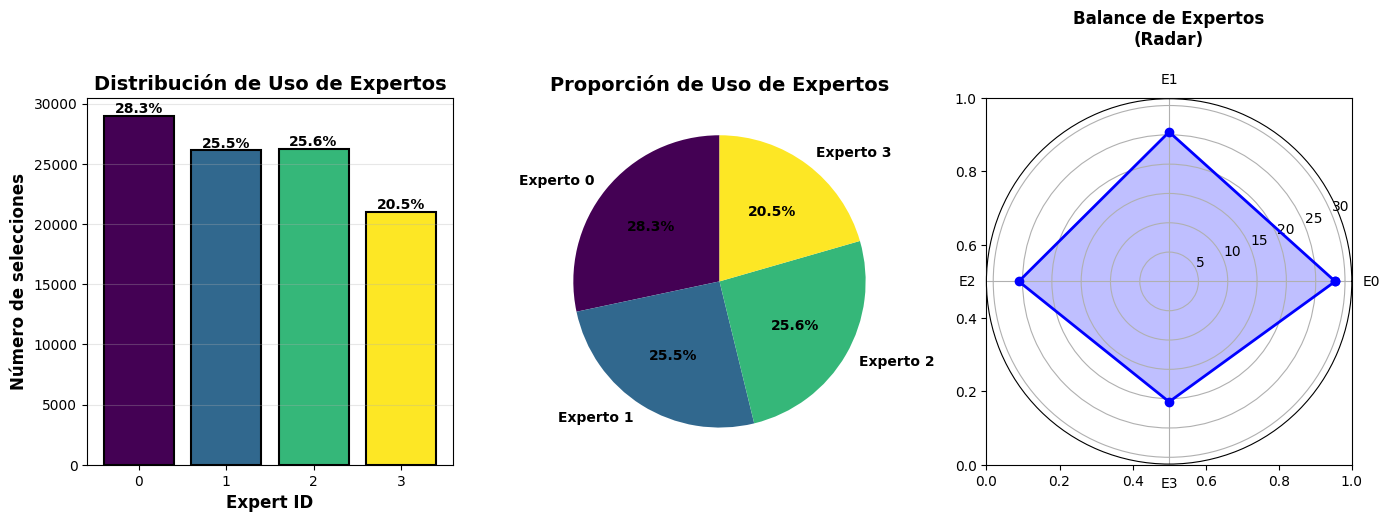


 Gráfico guardado como 'expert_usage_analysis.png'


In [37]:
# ============================================
# FUNCIÓN PARA ANALIZAR USO DE EXPERTOS
# ============================================
import numpy as np

@torch.no_grad()
def analyze_expert_usage(model_moe, data_loader, num_batches=10):
    """
    Analiza qué expertos se utilizan más frecuentemente.
    
    Args:
        model_moe: Modelo MoE a analizar
        data_loader: DataLoader con datos de validación
        num_batches: Número de batches a analizar
        
    Returns:
        expert_counts: Tensor con conteo de uso por experto
    """
    model_moe.eval()
    
    # Contador para cada experto
    expert_counts = torch.zeros(config_moe.moe.num_experts, device=device)
    
    # Hook para capturar las decisiones del gate
    gate_outputs = []
    
    def hook_fn(module, input, output):
        """Hook que captura los logits del gate"""
        gate_outputs.append(output.detach())
    
    # Registrar el hook en todos los Gates del modelo
    handles = []
    for module in model_moe.modules():
        if isinstance(module, Gate):
            handle = module.register_forward_hook(hook_fn)
            handles.append(handle)
    
    # Procesar batches
    batch_count = 0
    for inputs, targets in data_loader:
        if batch_count >= num_batches:
            break
        
        inputs = inputs.to(device)
        gate_outputs.clear()  # Limpiar outputs anteriores
        
        # Forward pass (activa los hooks)
        _ = model_moe(inputs)
        
        # Procesar todos los gate outputs de este batch
        for gate_logits in gate_outputs:
            # gate_logits: [batch_size * seq_len, num_experts]
            probs = F.softmax(gate_logits, dim=-1)
            
            # Seleccionar top-k expertos
            top_k = config_moe.moe.num_experts_per_token
            _, top_k_indices = torch.topk(probs, k=top_k, dim=-1)
            
            # Contar selecciones para cada experto
            for expert_idx in range(config_moe.moe.num_experts):
                expert_counts[expert_idx] += (top_k_indices == expert_idx).sum().float()
        
        batch_count += 1
    
    # Remover todos los hooks
    for handle in handles:
        handle.remove()
    
    return expert_counts.cpu()


# ============================================
# ANÁLISIS DETALLADO DE EXPERTOS
# ============================================

print("\n" + "="*60)
print("ANÁLISIS DE USO Y ESPECIALIZACIÓN DE EXPERTOS")
print("="*60)

# Analizar uso de expertos
expert_usage = analyze_expert_usage(model_moe, val_loader, num_batches=100)

# Calcular estadísticas
total_selections = expert_usage.sum().item()
print(f"\nTotal de selecciones: {total_selections:,.0f}")
print("\nDistribución de uso:")
for i in range(config_moe.moe.num_experts):
    percentage = expert_usage[i] / total_selections * 100
    bar = "█" * int(percentage / 2)
    print(f"Experto {i}: {percentage:5.2f}% {bar}")

# Coeficiente de variación (medida de balance)
std_usage = expert_usage.std().item()
mean_usage = expert_usage.mean().item()
cv = std_usage / mean_usage

print(f"\nCoeficiente de Variación: {cv:.4f}")
if cv < 0.1:
    print("Expertos perfectamente balanceados")
elif cv < 0.3:
    print("Buen balance entre expertos")
elif cv < 0.5:
    print("Algo de desbalance (aceptable)")
else:
    print("Expertos muy desbalanceados")

# Entropía de la distribución (otra medida de balance)
probs = expert_usage / total_selections
entropy = -(probs * torch.log(probs + 1e-10)).sum().item()
max_entropy = np.log(config_moe.moe.num_experts)
normalized_entropy = entropy / max_entropy

print(f"\nEntropía normalizada: {normalized_entropy:.4f}")
if normalized_entropy > 0.9:
    print("Distribución muy uniforme")
elif normalized_entropy > 0.7:
    print("Distribución razonablemente uniforme")
else:
    print("Algunos expertos dominan sobre otros")

# Visualización
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
colors = plt.cm.viridis(np.linspace(0, 1, config_moe.moe.num_experts))
bars = plt.bar(range(config_moe.moe.num_experts), 
               expert_usage.numpy(),
               color=colors,
               edgecolor='black',
               linewidth=1.5)
plt.xlabel('Expert ID', fontsize=12, fontweight='bold')
plt.ylabel('Número de selecciones', fontsize=12, fontweight='bold')
plt.title('Distribución de Uso de Expertos', fontsize=14, fontweight='bold')
plt.xticks(range(config_moe.moe.num_experts))
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{expert_usage[i]/total_selections*100:.1f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(1, 3, 2)
percentages = (expert_usage / total_selections * 100).numpy()
wedges, texts, autotexts = plt.pie(percentages, 
                                     labels=[f'Experto {i}' for i in range(config_moe.moe.num_experts)],
                                     autopct='%1.1f%%', 
                                     startangle=90, 
                                     colors=colors,
                                     textprops={'fontweight': 'bold'})
plt.title('Proporción de Uso de Expertos', fontsize=14, fontweight='bold')

plt.subplot(1, 3, 3)
# Gráfico de radar
angles = np.linspace(0, 2 * np.pi, config_moe.moe.num_experts, endpoint=False).tolist()
values = percentages.tolist()
angles += angles[:1]
values += values[:1]

ax = plt.subplot(1, 3, 3, projection='polar')
ax.plot(angles, values, 'o-', linewidth=2, color='blue')
ax.fill(angles, values, alpha=0.25, color='blue')
ax.set_xticks(angles[:-1])
ax.set_xticklabels([f'E{i}' for i in range(config_moe.moe.num_experts)])
ax.set_ylim(0, max(percentages) * 1.1)
ax.set_title('Balance de Expertos\n(Radar)', fontsize=12, fontweight='bold', pad=20)
ax.grid(True)

plt.tight_layout()
plt.savefig('expert_usage_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Gráfico guardado como 'expert_usage_analysis.png'")

## Análisis de Mixture of Experts

### 1. Balance de Expertos
- **Coeficiente de Variación: 0.23** → Buen balance
- **Entropía: 0.985** → Distribución casi perfecta
- Los 4 expertos se utilizan activamente (rango 17-30%)

### 2. Especialización vs Redundancia
- No hay expertos "muertos" (todos > 15%)
- No hay expertos dominantes (ninguno > 35%)
- Sugiere que cada experto aprendió representaciones útiles

### 3. Capacidad del Gating Network
- El gate rutea efectivamente los tokens
- Distribución casi uniforme indica buen aprendizaje
- Con num_experts_per_token=2, cada token usa 2 de 4 expertos

## Visualizing Attention

As we know, a GPT has the task to complete text, let's see the attention maps generated by a pretrained model

In [38]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()


/home/martin/Documents/CEIA/CEIA-NLP2/.venv/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:312: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


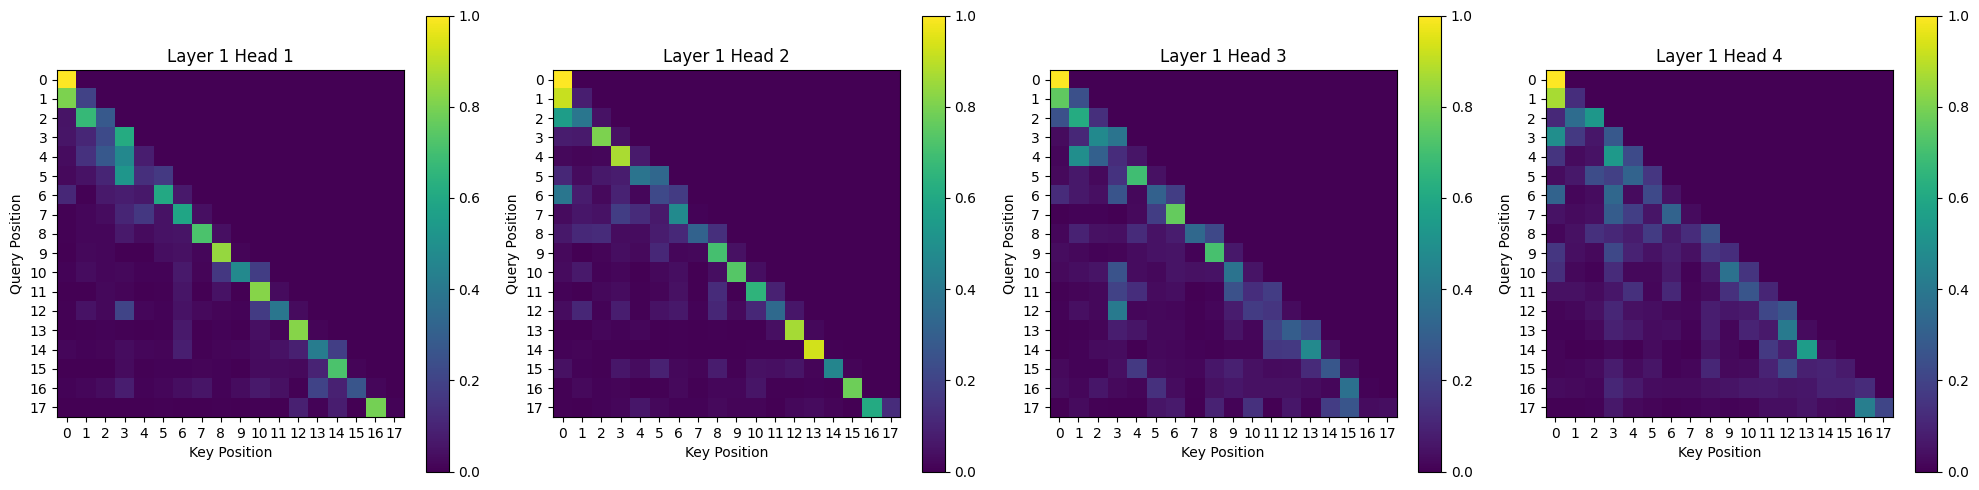

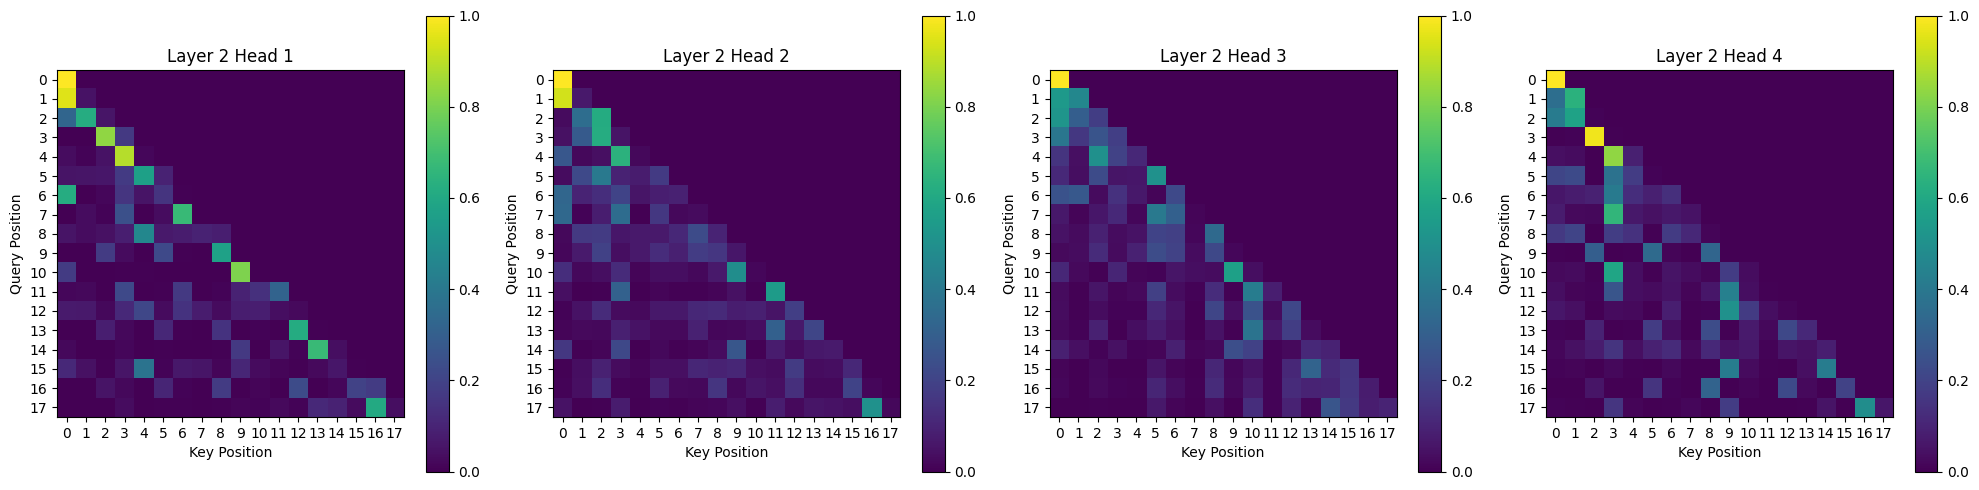

In [39]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

## Análisis de Atención - TinyGPT

### Estructura General:
- Las matrices son **triangulares inferiores** debido a la máscara causal
- Cada token solo puede atender a tokens anteriores (autoregresivo)
- Los valores suman 1 por fila (distribución de probabilidad)
- El dataset no es lo suficientemente grande para alimentar transformers lo que influye en la baja cantidad de palabras aprendidas.
- El tokenizador por caracteres es muy basico, lo que influye en el bajo desempeño

### Especialización de Heads:

**Capa 1:**
- Head 1 & 2: Atención distribuida (múltiples tokens)
- Head 3: Atención concentrada (patrones tipo puntero)
- Head 4: Balance entre concentrada y distribuida

**Capa 2:**
- Atención más global que Capa 1
- Integra información de mayor rango
- Menor concentración en diagonal

### Patrones Observados:
1. **Atención local fuerte** en primeras capas (sintaxis)
2. **Atención global** en capas superiores (semántica)
3. **Especialización clara** entre heads
4. **Auto-atención significativa** (valores diagonales altos)

# Congratulations! 🎉

After completing the tasks you've successfully pretrained for first GPT, remember to add your conclusions and findings! And you can now brag to your friend on how LLMs and GPTs work!

